<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/SIAM2021_Denoise_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical: Denoising Images 1 (MNIST)
(26/July/2021)

### 2021 Gene Golub SIAM Summer School 
https://sites.google.com/aims.ac.za/g2s3/home 

Instructor

<font color="green">***Dr. Emmanuel Dufourq*** 

www.emmanueldufourq.com

edufourq (['@']) gmail.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2021***

Material adapted from: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb

Code licensed under https://www.apache.org/licenses/LICENSE-2.0




## <font color="green"> Learning outcomes:

* implement the autoencoder using CNNs to denoise images

## <font color="green">Data information:

* Features: (28x28) images

* Output: (28x28) images

## <font color="green">Tasks for participants (boolean)?

* Yes, at the end (try avoid copy/pasting code, rather write it out)


## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In this prac we will train a network to remove noise from an image.

![Image denoising results](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png)

### Download the data

Again this is an unsupervised problem so we don't need the labels

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Normalise the data

Divide by the maximum pixel value, 255.

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train.shape

(60000, 28, 28)

### Reshape the data so that it has a 1 to indicate the depth of each image

In [ ]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
x_train.shape

(60000, 28, 28, 1)

### Create some noise

Adding random noise to the images

If you change the value of ```noise_factor``` you will make the resulting images more/less noisy.

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


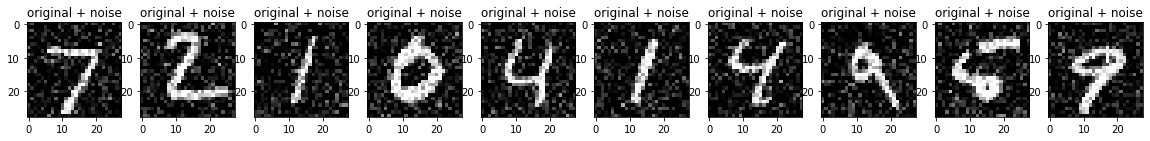

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Plot the original images

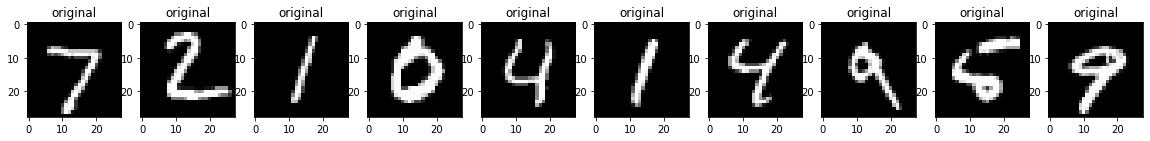

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

Instead of working on the class directly like in the last prac, let's build the encoder and decoded using the functional API separately to make sure we get the shapes correct.

### Encoder

Here we want to input an image of (28,28,1) and output a shape of (7,7,8) which is the encoded image.

So we need to build an appropriate architecture which will produce that output.



In [ ]:
# Here we use the Functional API which requires 3 things (Input, model and output)

# Specify the input layer here a shape of 28x28x1 (greyscale images)
encoder_input = tf.keras.Input(shape=(28, 28, 1))

# First conv layer which will reduce the shape by half given a stride of 2
encoder = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)

# Second conv layer which will reduce the shape by half given a stride of 2
encoder_output = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(encoder)

In [ ]:
# Create a Model and specify the input and output
# This is normal Keras functional API like in the ANN prac
model = tf.keras.Model(encoder_input, encoder_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


### Decoder

Here we want to input a shape of (7,7,8) and output an image of (28,28,1) which is the decoded image.

So we need to build an appropriate architecture which will produce that output.

The decoder is essentially the inverse of the encoder.

In [ ]:
# Here we use the Functional API which requires 3 things (Input, model and output)

# Specify the input layer here a shape of (16) (encoded images)
decoder_input = tf.keras.Input(shape=(7,7,8))

# Working backwards, we can to the opposite of Conv2D which is Transpose convolution. 
# API https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
decoder = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(decoder_input)

decoder = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(decoder)

# At this point our shape is (28,28,16) but we want (28,28,1) so we can remove the 16 features by
# applying a convolutional layer with 1 filter.
decoder_output = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder)

In [ ]:
model = tf.keras.Model(decoder_input, decoder_output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 8)]         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
del model, encoder, decoder, encoder_input, encoder_output, decoder_input, decoder_output

Now, let's take everything above and create our own Model object.

In [ ]:
from tensorflow.keras.initializers import HeNormal

class Autoencoder(Model):
  def __init__(self, name="autoencoder"):
    super(Autoencoder, self).__init__()

    # The Autoencoder has an encoder which we can make using normal layers
    # Here we use the Functional API which requires 3 things (Input, model and output)
    # ------------------------------------------
    # Specify the input layer here a shape of 28x28x1 (greyscale images)
    self.encoder_input = tf.keras.Input(shape=(28, 28, 1))

    self.encoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal())(self.encoder_input)

    self.encoder_output = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=HeNormal())(self.encoder)

    self.encoder_model = tf.keras.Model(self.encoder_input, self.encoder_output)
    # ------------------------------------------

    # The Autoencoder has an decoder  which we can make using normal layers
    # Here we use the Functional API which requires 3 things (Input, model and output)
    # ------------------------------------------

    self.decoder_input = tf.keras.Input(shape=(7,7,8))

    self.decoder = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same', kernel_initializer=HeNormal())(self.decoder_input)
    self.decoder = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same', kernel_initializer=HeNormal())(self.decoder)
    self.decoder_output = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_initializer=HeNormal())(self.decoder)

    self.decoder_model = tf.keras.Model(self.decoder_input, self.decoder_output)
    # ------------------------------------------

  # The forward pass
  def call(self, x):

    # Encode the inputs x using the propery defined above
    # In the previous notebook we created the encoder and decoder as Sequential Models
    # but now since we used the Functional API we need to call the Model objects we created above
    encoded = self.encoder_model(x)

    # Decode the encoded vector using the property defined above
    decoded = self.decoder_model(encoded)

    # Return the decoded (28,28) data
    return decoded
    
autoencoder = Autoencoder() 

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=6,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/6
1875/1875 [==============================] - 38s 3ms/step - loss: 0.1039 - val_loss: 0.0744
Epoch 2/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0740 - val_loss: 0.0728
Epoch 3/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0730 - val_loss: 0.0724
Epoch 4/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0724 - val_loss: 0.0718
Epoch 5/6
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0721 - val_loss: 0.0715
Epoch 6/6
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0719 - val_loss: 0.0720


In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 7, 7, 8)           1320      
_________________________________________________________________
model_3 (Functional)         (None, 28, 28, 1)         1897      
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


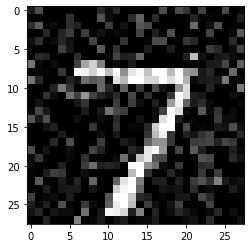

In [ ]:
plt.imshow(x_test_noisy[0,:,:,0])
plt.gray()

In [ ]:
encoded_img = autoencoder.encoder_model(np.expand_dims(x_test_noisy[0],0)).numpy()

In [ ]:
encoded_img.shape

(1, 7, 7, 8)

In [ ]:
decoded_img = autoencoder.decoder_model(encoded_img).numpy()

In [ ]:
decoded_img.shape

(1, 28, 28, 1)

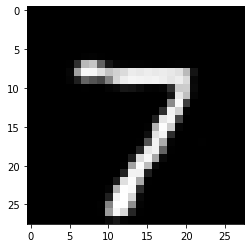

In [ ]:
plt.imshow(decoded_img[0,:,:,0])
plt.gray()

## Now let's compare the original images to the recontructed images on all of the testing data

In [ ]:
encoded_imgs = autoencoder.encoder_model(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder_model(encoded_imgs).numpy()

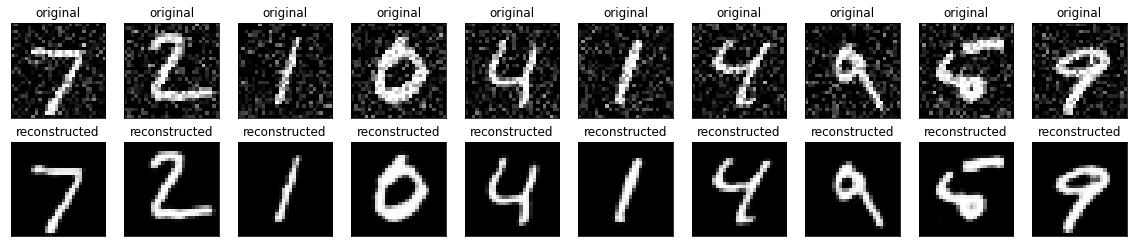

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noisy[i,:,:,0])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i,:,:,0])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Task:

* Explore modifications to the encoder and decoder (i.e. different conv layers in the encoder and decover).

* Try different values for the noise.

* What about using a different loss function? Does it always produce good results, say meansquared error.

